# GeoPython 2018 lightning talk
Presented at the [GeoPython 2018](http://2018.geopython.net/) conference in Muttenz, Basel.

To run this notebook you'll have to minimally:
- install the python libraries imported in the next cell below (conda and some via pip)
- download the [Stanford Named Entity Recognizer (NER)](https://nlp.stanford.edu/software/CRF-NER.shtml); I use v3.8.0 which you can [download here](https://nlp.stanford.edu/software/stanford-ner-2017-06-09.zip), unzip, then adjust the `CLASSPATH` and `STANFORD_MODELS` paths in the next cell below
- use nltk.download() to download nltk models
- set a data path for `nltk` if you get a `LookupError` from nltk below even after downloading relevant models (also next cell below)

In [1]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster # for marker clusters
import nltk
import nltk.data
from nltk.tag import StanfordNERTagger
import os
import time
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# IMPORTANT SETUP STUFF 
# you might need a data path like this if NLTK doesn't find things
nltk.data.path.append('C:\\Data\\NLTK')
# adjust these paths to your Stanford NER folder location
os.environ['CLASSPATH'] =  'stanford-ner-2017-06-09\\'
os.environ['STANFORD_MODELS'] = 'stanford-ner-2017-06-09\\classifiers'

## Read in some simple documents (Geograph photo info)

In [2]:
# file with some geograph sample data in a csv
path_to_data = 'geograph_random_sample.csv'
df = pd.read_csv(path_to_data, sep=";", encoding='utf-8')
print("We have %s documents." %df.shape[0])
df.head()

We have 500 documents.


,gridimage_id,user_id,wgs84_lat,wgs84_long,imageclass,comment,tags
0,116672,2798,51.655438,-0.396803,Street scene,A contrast in building styles at the entrance ...,None
1,579865,2282,54.605729,-7.303270,Offices,This picture was completed by stitching three ...,None
2,2473083,22742,53.443920,-2.067710,None,Looking from near the chapel towards the main ...,"top:Burial ground, Crematorium?Cemetery?place:..."
3,656641,17441,52.953889,-1.150490,City scene,Ever since first seeing the Old Market Square ...,None
4,765323,7185,57.143792,-2.073353,Building,These 'temporary' looking buildings stand side...,None


## Plot the coordinates quickly

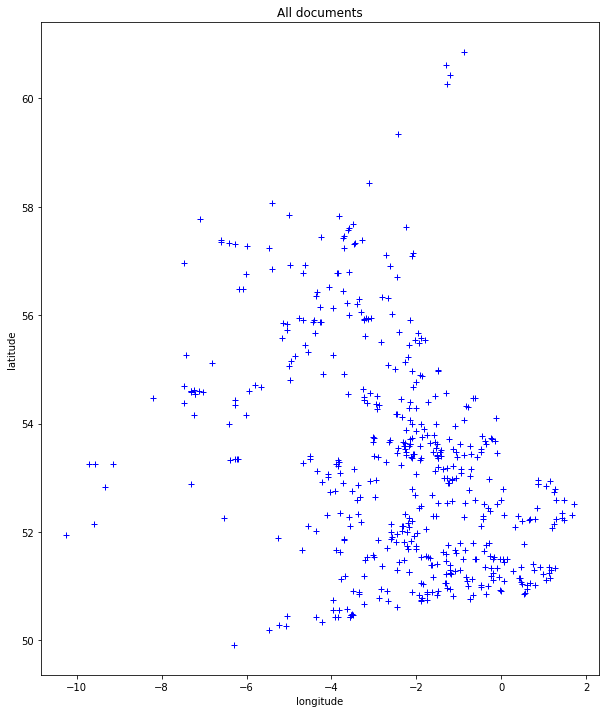

In [3]:
# let's plot all the points quickly
plt.figure(figsize=(10,12))
plt.plot(df['wgs84_long'], df['wgs84_lat'], 'b+')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("All documents")
plt.show()

## Coordinates in a map using folium

Let's show the picture markers (GPS tags) on an OSM basemap.

In [4]:
# let's get a point map over an OSM basemap for a sample (n=50 here)
df_sample = df.sample(n=50)
map_osm = folium.Map(location=[55.0, -4.00], zoom_start=5, tiles='OpenStreetMap')

for row in df_sample.itertuples():
    lat = row[3]
    lon = row[4]
    text = row[6]
    popup = folium.Popup(text, parse_html=True)
    folium.Marker([lat, lon], popup=popup).add_to(map_osm)
    
map_osm

Here it's done using the leaflet cluster renderer / the folium MarkerCluster:

In [5]:
lats = df['wgs84_lat'].tolist()
lons = df['wgs84_long'].tolist()
coordinates = list(zip(lats, lons))
texts = df['comment'].tolist()
popups = [folium.Popup(t, parse_html=True) for t in texts]

map_cluster = folium.Map(location=[55.0, -4.00], zoom_start=5, tiles='Cartodb Positron')
map_cluster.add_child(MarkerCluster(locations=coordinates, popups=popups))
map_cluster

## Extract locations using nltk and Stanford NER

Let's demo location tagging and mapping using a random document (random dataframe row).

In [6]:
def geocode_nominatim(querytext, return_geometry=False, country_codes=None, return_list=False):
    """
    Query OSM Nominatim over HTTP requests done using the 'requests' library.
    :param querytext: single-line query text to geocode
    :param return_geometry: whether to return a geojson if there is one; default to False.
    :param country_codes: optionally specify a 2-letter country code, or a list of 2-letter country codes to limit the search
    :param return_list: whether to return the list of results; defaults to False, returning just the top result.
    :return: the top result, or the full list (see param return_list); may return None.
    """
    url = "http://nominatim.openstreetmap.org/search"
    parameters = {'format':'json', 'q':querytext}
    if return_geometry:
        parameters['polygon_geojson'] = '1'
    if country_codes:
        if isinstance(country_codes, list):
            parameters['countrycodes'] = ', '.join(cc for cc in country_codes)
        elif isinstance(country_codes, str) and len(country_codes)==2:
            parameters['countrycodes'] = country_codes
        else:
            print("country_codes was in the wrong format. ignoring this parameter.")

    # the magic from requests library
    r = requests.post(url, params = parameters)

    json = r.json()
    if return_list:
        return json
    if json:
        return json[0]

    return None

def extract_locations_from_list(tagged):
    """
    Concatenate consecutive sequences of 'LOCATION'-tagged terms from a list.
    """
    locations = []
    for sentence in tagged:
        concatenate = False
        loc = ''
        for token in sentence:
            if token[1] == 'LOCATION':
                if concatenate:
                    loc += ' ' + token[0]
                else:
                    loc = token[0]
                    concatenate = True
            else:
                if loc:
                    locations.append(loc)
                concatenate = False
                loc = ''

    return locations


In [7]:
# start from a random document (i.e. a random row)
#random_row = df.sample().iloc[0]
# specific document for the live demo
random_row = df[df['gridimage_id'] == 2302263].iloc[0]
random_row

gridimage_id                                              2302263
user_id                                                     60493
wgs84_lat                                                 53.5294
wgs84_long                                               -2.25687
imageclass                                                  Geese
comment             Geese at Heaton Park, in Manchester, England.
tags            geese?place:Greater Manchester?Greater Manches...
Name: 387, dtype: object

In [8]:
# display the original text we want to map
random_row['comment']

'Geese at Heaton Park, in Manchester, England.'

In [9]:
text = random_row.loc['comment']
gps = [random_row.loc['wgs84_lat'], random_row.loc['wgs84_long']]

# break text up into sentences, then sentences up into words, then do NER tagging
sentences = nltk.sent_tokenize(text)
sentences = [nltk.word_tokenize(sent) for sent in sentences]

# create an NER tagger from a particular model (3 class model, here)
tagger = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')
tagged = [tagger.tag(sent) for sent in sentences]
print("Stanford NER tagged sentence:")
print(tagged)

Stanford NER tagged sentence:
[[('Geese', 'O'), ('at', 'O'), ('Heaton', 'LOCATION'), ('Park', 'LOCATION'), (',', 'O'), ('in', 'O'), ('Manchester', 'LOCATION'), (',', 'O'), ('England', 'LOCATION'), ('.', 'O')]]


In [10]:
locations = extract_locations_from_list(tagged)
print("Original text: %s" %text)
print("Locations found: %s" %locations)

Original text: Geese at Heaton Park, in Manchester, England.
Locations found: ['Heaton Park', 'Manchester', 'England']


In [11]:
9# create map
map_result = folium.Map(gps, zoom_start = 12, tiles='OpenStreetMap')
# plot gps point with a 'photo' icon
folium.Marker(location=gps, popup=text, icon=folium.Icon(prefix='fa', color='blue', icon='photo')).add_to(map_result)
if len(locations) > 0:
    geometries = {'points':[], 'geojson':[]}  # i.e. what we'll get back from geocoding
    for location in locations:
        # get just top result
        result = geocode_nominatim(location, return_geometry=True, country_codes='gb')
        if result:
            print("found a result: " + result['display_name'])
            centroid = [float(result['lat']), float(result['lon'])]
            # store as ([lat,lon], geocode_text, geocode_result) tuple
            geometries['points'].append((centroid, location, result['display_name']))
            if result['geojson']:
                geometries['geojson'].append((result['geojson'], location, result['display_name']))

        time.sleep(1)

    # now prepare the markers with info from the documents
    for geometry in geometries['points']:
        popup_text = 'geocoded text: ' + geometry[1] + '; display text: ' + geometry[2]
        popup = folium.Popup(popup_text, parse_html=True)
        folium.Marker(geometry[0], popup=popup).add_to(map_result)
    print("found %s geojson geometries" %len(geometries['geojson']))
    for geometry in geometries['geojson']:
        geojson = geometry[0]
        print("geometry type: " + geojson['type'])
        #print("geometry coordinates: " + str(geojson['coordinates']))
        folium.GeoJson(data=geojson).add_to(map_result)  # TODO: how to add a popup?

map_result

found a result: Heaton Park, Crumpsall, Manchester, Greater Manchester, North West England, England, UK
found a result: Manchester, Greater Manchester, North West England, England, UK
found a result: England, UK
found 3 geojson geometries
geometry type: Polygon
geometry type: Polygon
geometry type: Polygon


## Save the map to an html file

In [12]:
# save the map to an html file
filename = text[:10].replace(' ', '-').lower() + '.html'
map_result.save(filename)

# python libraries used:

- [nltk](http://www.nltk.org/) (Natural Language ToolKit) for sentence tokenization and access to Stanford NER from python
- [folium](https://github.com/python-visualization/folium) to generate [Leaflet](https://leafletjs.com/) maps
- [requests](http://docs.python-requests.org/en/master/) for geocoding requests to OSM Nominatim
- [pandas](http://pandas.pydata.org/) to read in the CSV data (useful but not necessary)

# other resources used:

- [Geograph](https://www.geograph.org.uk/) for GPS-tagged photos with descriptions (text to map)
- [Stanford NER](https://nlp.stanford.edu/software/CRF-NER.shtml) (Named Entity Recognition) v3.8.0, accessed via nltk
- [OSM Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim) for geocoding textual locations
